# Random Forest

### 1. Import Library

In [21]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix

### 2. Load and explore data

In [3]:
DATA_PATH = os.path.join("..", "DataSet", "SPU_D.xlsx")
df = pd.read_excel(DATA_PATH)

C:\Users\WIN 10 PRO 22H2\AppData\Roaming\Python\Python312\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


### 3. เลือกเฉพาะคอลัมน์ Content และ Report time

In [4]:
df = df[['Content', 'Report time']]

### 4. แปลงข้อมูลในคอลัมน์ Report time เป็น datetime

In [5]:
df['Report time'] = pd.to_datetime(df['Report time'])

### 5. ดึงค่าจาก Content โดยการแยกค่าต่าง ๆ (เช่น PM2.5, CO2, Temp) ออกมาเป็นคอลัมน์ใหม่

In [ ]:
# df['QUALITY'] = df['Content'].str.extract(r'QUALITY:(\d+\.?\d*)').astype(float)
df['PM2.5'] = df['Content'].str.extract(r'PM2.5:(\d+\.?\d*)').astype(float)
df['CO2'] = df['Content'].str.extract(r'CO2:(\d+\.?\d*)').astype(float)
df['Temp'] = df['Content'].str.extract(r'Temp:(\d+\.?\d*)').astype(float)
df['humid'] = df['Content'].str.extract(r'humid:(\d+\.?\d*)').astype(float)
df['VOC'] = df['Content'].str.extract(r'VOC:(\d+\.?\d*)').astype(float)
df['HCHO'] = df['Content'].str.extract(r'HCHO:(\d+\.?\d*)').astype(float)

### 6. แยก `Report time` เป็นวันและเวลา

In [7]:
df['Date'] = df['Report time'].dt.strftime('%Y-%m-%d')
df['Time'] = df['Report time'].dt.strftime('%H:%M:%S')

In [8]:
# # Export เป็นไฟล์ Excel
# df.to_excel('output.xlsx', index=False)

# print("DataFrame exported to output.xlsx") #แจ้งว่า export สำเร็จ

### 7. จัดการ Missing Values (กรณีบางค่าอาจหายไปในบางแถว)

In [9]:
print(df.dtypes)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
print(df.isnull().sum())


Content                object
Report time    datetime64[ns]
QUALITY               float64
PM2.5                 float64
CO2                   float64
Temp                  float64
humid                 float64
VOC                   float64
HCHO                  float64
Date                   object
Time                   object
dtype: object
Content        0
Report time    0
QUALITY        0
PM2.5          0
CO2            0
Temp           0
humid          0
VOC            0
HCHO           0
Date           0
Time           0
dtype: int64


### 8. เลือก Features และ Target (สมมติว่าเราอยากทำนาย `AQI_Level` หรือ `Quality_Level`)
 
 ในกรณีนี้ สมมุติว่าเรามีตัวแปร `Quality_Level` ที่กำหนดคุณภาพอากาศ เช่น 'Good', 'Moderate', 'Bad'

In [10]:
X = df[['PM2.5', 'Temp', 'humid', 'VOC', 'HCHO']]  # Feature
y = df['CO2']  # Target (เปลี่ยนให้ตรงกับข้อมูลของคุณ)

### 9. แบ่งข้อมูลเป็น Train และ Test

In [11]:
# # แปลงค่า CO2 เป็นค่าแยก (categorical)
# bins = [0, 400, 800, float('inf')]
# labels = [0, 1, 2]  # คลาส 0: ต่ำ, คลาส 1: ปานกลาง, คลาส 2: สูง
# y_categorical = pd.cut(y, bins=bins, labels=labels, right=False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 10. Scaling ข้อมูล (สำหรับ Random Forest สามารถใช้ได้ทั้ง Scaling หรือไม่ใช้)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 11. Train Random Forest Model

In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(n_estimators=10, random_state=42)

### 12. ทำนายผล

In [15]:
y_pred = rf.predict(X_test_scaled)

### 13. วัดผล Model

In [16]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 61.42064935937206
Mean Absolute Error (MAE): 4.293858655508787
R-squared (R2): 0.966944547791589


### 14. แสดง Confusion Matrix

### 15. วิเคราะห์ Feature Importance

C:\Users\WIN 10 PRO 22H2\AppData\Local\Temp\ipykernel_20988\1292790911.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, palette='viridis')


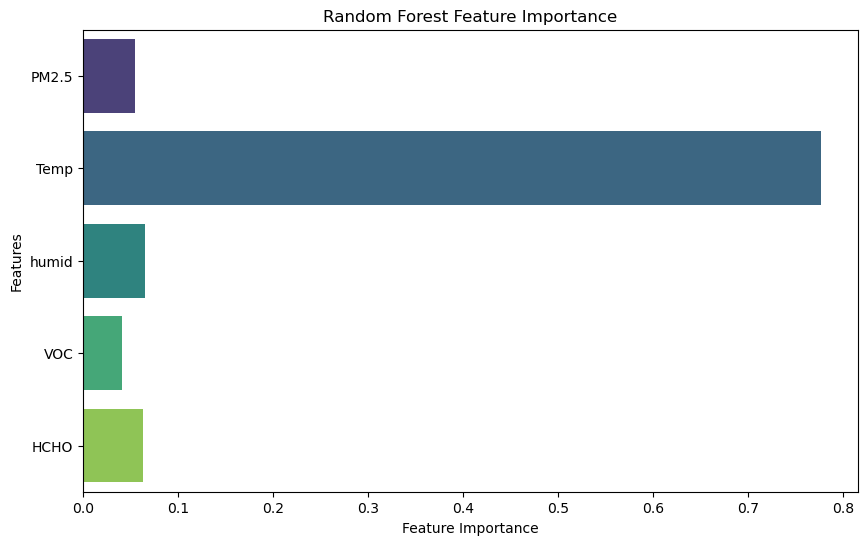

In [17]:
feature_importance = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

### 16. บันทึกโมเดลและ Scaler ด้วย joblib

In [18]:
joblib.dump(rf, 'random_forest_model.pkl')  # บันทึกโมเดล
joblib.dump(scaler, 'scaler.pkl')  # บันทึก Scaler

['scaler.pkl']

### 17. โหลดโมเดลและ Scaler ที่บันทึกไว้

In [19]:
loaded_rf = joblib.load('random_forest_model.pkl')  # โหลดโมเดลที่ฝึกแล้ว
loaded_scaler = joblib.load('scaler.pkl')  # โหลด Scaler ที่บันทึกไว้

### 18. เตรียมข้อมูลใหม่สำหรับทำนาย

In [20]:
new_data = np.array([[30, 400, 27.5, 70, 12, 5, 0]])  # เพิ่ม 0 สำหรับ DayOfWeek
new_data_scaled = loaded_scaler.transform(new_data)
print(new_data_scaled)

c:\Users\WIN 10 PRO 22H2\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: X has 7 features, but StandardScaler is expecting 5 features as input.

### 19. ทำนายผลจากข้อมูลใหม่

In [ ]:
prediction = loaded_rf.predict(new_data_scaled)

print("🔮 การทำนายคุณภาพอากาศ: ", prediction)

🔮 การทำนายคุณภาพอากาศ:  [1586.8]
